# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
import matplotlib.ticker as mticks
import glob
import holidays
import datetime as dt
from holidays import country_holidays
from matplotlib import ticker
import statsmodels.tsa.api as tsa
from statsmodels.tools.tools import add_constant
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm
import os

# Functions

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

# Data

In [6]:
# Use glob to get all filepaths that match the pattern (*=wildcard)
glob = sorted(glob.glob("Data/Chicago-Crime_2*.csv"))
glob

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [7]:
# Use read_csv in a list comprehension and combine with concat to load all files
chicago_full= pd.concat([pd.read_csv(f) for f in glob] )

In [8]:
chicago_full

ID                    Date        Primary Type  \
0        1326041  01/01/2001 01:00:00 AM             BATTERY   
1        1319931  01/01/2001 01:00:00 PM             BATTERY   
2        1324743  01/01/2001 01:00:00 PM            GAMBLING   
3        1310717  01/01/2001 01:00:00 AM     CRIMINAL DAMAGE   
4        1318099  01/01/2001 01:00:00 AM             BATTERY   
...          ...                     ...                 ...   
238853  12938029  12/31/2022 12:50:00 PM             ASSAULT   
238854  12937822  12/31/2022 12:50:00 PM             ASSAULT   
238855  12937583  12/31/2022 12:52:00 AM             BATTERY   
238856  12938420  12/31/2022 12:52:00 PM             ASSAULT   
238857  12939906  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                    Description          Location Description  \
0                                        SIMPLE                     RESIDENCE   
1                                        SIMPLE                     RESIDENCE   
2                           ILLEGAL ILL LOTTERY                        STREET   
3                                    TO VEHICLE                        STREET   
4                                        SIMPLE       RESIDENCE PORCH/HALLWAY   
...                                         ...                           ...   
238853                                   SIMPLE                     APARTMENT   
238854                     AGGRAVATED - HANDGUN                     APARTMENT   
238855                                   SIMPLE                    BARBERSHOP   
238856                                   SIMPLE  COMMERCIAL / BUSINESS OFFICE   
238857  FINANCIAL IDENTITY THEFT $300 AND UNDER                     RESIDENCE   

        Arrest  Domestic  Beat  District  Ward   Latitude  Longitude  
0        False     False  1624      16.0   NaN  41.957850 -87.749185  
1        False      True   825       8.0   NaN  41.783892 -87.684841  
2         True     False   313       3.0   NaN  41.780412 -87.611970  
3        False     False  2424      24.0   NaN  42.012391 -87.678032  
4        False      True   214       2.0   NaN  41.819538 -87.620020  
...        ...       ...   ...       ...   ...        ...        ...  
238853   False     False  1014      10.0  24.0  41.855911 -87.719966  
238854   False      True   733       7.0   6.0  41.766546 -87.645669  
238855   False     False  1135      11.0  28.0  41.868829 -87.686098  
238856   False     False  1432      14.0  32.0  41.930693 -87.685657  
238857   False     False  1511      15.0  29.0        NaN        NaN  

[7713109 rows x 12 columns]

# Preparing the Dataframe

In [9]:
# this cell can take up to 1 min to run
date_format = "%m/%d/%Y %H:%M:%S %p"

chicago_full['Datetime'] = pd.to_datetime(chicago_full['Date'], format=date_format)
chicago_full = chicago_full.sort_values('Datetime')
chicago_full

ID                    Date        Primary Type  \
0        1326041  01/01/2001 01:00:00 AM             BATTERY   
29       1317937  01/01/2001 01:00:00 AM             BATTERY   
31       1310824  01/01/2001 01:00:00 AM               THEFT   
32       1313086  01/01/2001 01:00:00 PM               THEFT   
33       1310858  01/01/2001 01:00:00 PM       OTHER OFFENSE   
...          ...                     ...                 ...   
238853  12938029  12/31/2022 12:50:00 PM             ASSAULT   
238854  12937822  12/31/2022 12:50:00 PM             ASSAULT   
238855  12937583  12/31/2022 12:52:00 AM             BATTERY   
238856  12938420  12/31/2022 12:52:00 PM             ASSAULT   
238857  12939906  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                    Description          Location Description  \
0                                        SIMPLE                     RESIDENCE   
29                                       SIMPLE       RESIDENCE PORCH/HALLWAY   
31                               $500 AND UNDER                 BAR OR TAVERN   
32                                    OVER $500                         OTHER   
33                             TELEPHONE THREAT                     RESIDENCE   
...                                         ...                           ...   
238853                                   SIMPLE                     APARTMENT   
238854                     AGGRAVATED - HANDGUN                     APARTMENT   
238855                                   SIMPLE                    BARBERSHOP   
238856                                   SIMPLE  COMMERCIAL / BUSINESS OFFICE   
238857  FINANCIAL IDENTITY THEFT $300 AND UNDER                     RESIDENCE   

        Arrest  Domestic  Beat  District  Ward   Latitude  Longitude  \
0        False     False  1624      16.0   NaN  41.957850 -87.749185   
29       False     False   334       3.0   NaN  41.762514 -87.565877   
31       False     False   323       3.0   NaN  41.765484 -87.621836   
32       False     False  1732      17.0   NaN  41.953070 -87.716716   
33       False     False  1724      17.0   NaN  41.955619 -87.708919   
...        ...       ...   ...       ...   ...        ...        ...   
238853   False     False  1014      10.0  24.0  41.855911 -87.719966   
238854   False      True   733       7.0   6.0  41.766546 -87.645669   
238855   False     False  1135      11.0  28.0  41.868829 -87.686098   
238856   False     False  1432      14.0  32.0  41.930693 -87.685657   
238857   False     False  1511      15.0  29.0        NaN        NaN   

                  Datetime  
0      2001-01-01 01:00:00  
29     2001-01-01 01:00:00  
31     2001-01-01 01:00:00  
32     2001-01-01 01:00:00  
33     2001-01-01 01:00:00  
...                    ...  
238853 2022-12-31 12:50:00  
238854 2022-12-31 12:50:00  
238855 2022-12-31 12:52:00  
238856 2022-12-31 12:52:00  
238857 2022-12-31 12:59:00  

[7713109 rows x 13 columns]

In [10]:
chicago_full['Datetime'].dt.month

0          1
29         1
31         1
32         1
33         1
          ..
238853    12
238854    12
238855    12
238856    12
238857    12
Name: Datetime, Length: 7713109, dtype: int64

In [11]:
## Dropping unneeded columns to reduce file size
drop_cols = ['Latitude', 'Longitude', 'Ward', 'Beat', 'ID', ]

In [12]:
# save final df
chicago_final = chicago_full.drop(columns=drop_cols)
chicago_final = chicago_final.set_index('Datetime')
chicago_final

Date        Primary Type  \
Datetime                                                          
2001-01-01 01:00:00  01/01/2001 01:00:00 AM             BATTERY   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM             BATTERY   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM               THEFT   
2001-01-01 01:00:00  01/01/2001 01:00:00 PM               THEFT   
2001-01-01 01:00:00  01/01/2001 01:00:00 PM       OTHER OFFENSE   
...                                     ...                 ...   
2022-12-31 12:50:00  12/31/2022 12:50:00 PM             ASSAULT   
2022-12-31 12:50:00  12/31/2022 12:50:00 PM             ASSAULT   
2022-12-31 12:52:00  12/31/2022 12:52:00 AM             BATTERY   
2022-12-31 12:52:00  12/31/2022 12:52:00 PM             ASSAULT   
2022-12-31 12:59:00  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                                 Description  \
Datetime                                                       
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                           $500 AND UNDER   
2001-01-01 01:00:00                                OVER $500   
2001-01-01 01:00:00                         TELEPHONE THREAT   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                             Location Description  Arrest  Domestic  District  
Datetime                                                                       
2001-01-01 01:00:00                     RESIDENCE   False     False      16.0  
2001-01-01 01:00:00       RESIDENCE PORCH/HALLWAY   False     False       3.0  
2001-01-01 01:00:00                 BAR OR TAVERN   False     False       3.0  
2001-01-01 01:00:00                         OTHER   False     False      17.0  
2001-01-01 01:00:00                     RESIDENCE   False     False      17.0  
...                                           ...     ...       ...       ...  
2022-12-31 12:50:00                     APARTMENT   False     False      10.0  
2022-12-31 12:50:00                     APARTMENT   False      True       7.0  
2022-12-31 12:52:00                    BARBERSHOP   False     False      11.0  
2022-12-31 12:52:00  COMMERCIAL / BUSINESS OFFICE   False     False      14.0  
2022-12-31 12:59:00                     RESIDENCE   False     False      15.0  

[7713109 rows x 7 columns]

# Resampling the Dataframe

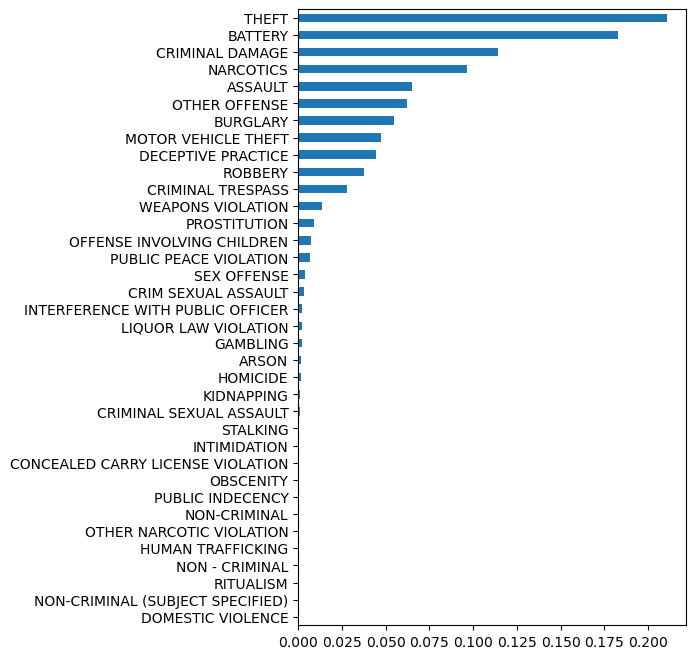

In [13]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_final['Primary Type'].value_counts(normalize=True)
crime_counts.sort_values().plot(kind='barh',figsize=(5,8));

In [14]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_final['Primary Type'].value_counts().to_frame('Total # of Crimes')
crime_counts

Total # of Crimes
THEFT                                        1626992
BATTERY                                      1410889
CRIMINAL DAMAGE                               878914
NARCOTICS                                     746155
ASSAULT                                       501103
OTHER OFFENSE                                 479174
BURGLARY                                      422246
MOTOR VEHICLE THEFT                           366586
DECEPTIVE PRACTICE                            340958
ROBBERY                                       289677
CRIMINAL TRESPASS                             212869
WEAPONS VIOLATION                             103906
PROSTITUTION                                   69750
OFFENSE INVOLVING CHILDREN                     55280
PUBLIC PEACE VIOLATION                         52086
SEX OFFENSE                                    30442
CRIM SEXUAL ASSAULT                            27584
INTERFERENCE WITH PUBLIC OFFICER               18206
LIQUOR LAW VIOLATION                           14846
GAMBLING                                       14616
ARSON                                          13121
HOMICIDE                                       12394
KIDNAPPING                                      7185
CRIMINAL SEXUAL ASSAULT                         6353
STALKING                                        4664
INTIMIDATION                                    4595
CONCEALED CARRY LICENSE VIOLATION               1019
OBSCENITY                                        810
PUBLIC INDECENCY                                 193
NON-CRIMINAL                                     181
OTHER NARCOTIC VIOLATION                         147
HUMAN TRAFFICKING                                 96
NON - CRIMINAL                                    38
RITUALISM                                         24
NON-CRIMINAL (SUBJECT SPECIFIED)                   9
DOMESTIC VIOLENCE                                  1

In [15]:
## MAking a dictionary for crimes
CRIMES = {}

In [16]:
# 1. get list of  unique crime descriptions
crime_list = chicago_final['Primary Type'].unique()
crime_list

array(['BATTERY', 'THEFT', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT',
       'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'ASSAULT', 'CRIMINAL DAMAGE',
       'BURGLARY', 'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN',
       'GAMBLING', 'DECEPTIVE PRACTICE', 'NARCOTICS', 'WEAPONS VIOLATION',
       'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING',
       'PROSTITUTION', 'STALKING', 'INTIMIDATION',
       'CRIMINAL SEXUAL ASSAULT', 'ARSON', 'RITUALISM',
       'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION',
       'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'], dtype=object)

In [17]:
# 2. Create an empty dictionary  
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
   temp = chicago_final.loc[ chicago_final['Primary Type']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("D").size() 
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
CRIMES.keys()

dict_keys(['BATTERY', 'THEFT', 'OTHER OFFENSE', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'ASSAULT', 'CRIMINAL DAMAGE', 'BURGLARY', 'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'GAMBLING', 'DECEPTIVE PRACTICE', 'NARCOTICS', 'WEAPONS VIOLATION', 'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS', 'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING', 'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'CRIMINAL SEXUAL ASSAULT', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'])

In [18]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df

BATTERY  THEFT  OTHER OFFENSE  MOTOR VEHICLE THEFT  \
Datetime                                                         
2001-01-01      296    412            167                   60   
2001-01-02      143    221            101                   65   
2001-01-03      165    226             96                   72   
2001-01-04      173    243             96                   87   
2001-01-05      178    265             90                   86   
...             ...    ...            ...                  ...   
2022-12-27       76    147             33                   77   
2022-12-28      102    112             38                  103   
2022-12-29       97    137             37                   95   
2022-12-30      106    125             38                   95   
2022-12-31      122    102             37                   88   

            CRIM SEXUAL ASSAULT  SEX OFFENSE  ASSAULT  CRIMINAL DAMAGE  \
Datetime                                                                 
2001-01-01                 38.0           65       70              233   
2001-01-02                  2.0            4       66              118   
2001-01-03                  7.0            5       79              136   
2001-01-04                  2.0            1       57              133   
2001-01-05                  6.0            2       68              142   
...                         ...          ...      ...              ...   
2022-12-27                  NaN            2       47               64   
2022-12-28                  NaN            0       44               78   
2022-12-29                  NaN            3       38               95   
2022-12-30                  NaN            0       51              100   
2022-12-31                  NaN            3       62              128   

            BURGLARY  PUBLIC PEACE VIOLATION  ...  RITUALISM  \
Datetime                                      ...              
2001-01-01        66                       5  ...        NaN   
2001-01-02        68                       2  ...        NaN   
2001-01-03        57                       7  ...        NaN   
2001-01-04        55                       3  ...        NaN   
2001-01-05        55                       5  ...        NaN   
...              ...                     ...  ...        ...   
2022-12-27        17                       1  ...        NaN   
2022-12-28        23                       1  ...        NaN   
2022-12-29        29                       2  ...        NaN   
2022-12-30        18                       2  ...        NaN   
2022-12-31        21                       1  ...        NaN   

            DOMESTIC VIOLENCE  OBSCENITY  OTHER NARCOTIC VIOLATION  \
Datetime                                                             
2001-01-01                NaN        NaN                       NaN   
2001-01-02                NaN        NaN                       NaN   
2001-01-03                NaN        NaN                       NaN   
2001-01-04                NaN        NaN                       NaN   
2001-01-05                NaN        NaN                       NaN   
...                       ...        ...                       ...   
2022-12-27                NaN        NaN                       NaN   
2022-12-28                NaN        NaN                       NaN   
2022-12-29                NaN        NaN                       NaN   
2022-12-30                NaN        NaN                       NaN   
2022-12-31                NaN        NaN                       NaN   

            PUBLIC INDECENCY  CONCEALED CARRY LICENSE VIOLATION  NON-CRIMINAL  \
Datetime                                                                        
2001-01-01               NaN                                NaN           NaN   
2001-01-02               NaN                                NaN           NaN   
2001-01-03               NaN                                NaN           NaN   
2001-01-04               NaN             

# Answering 3 questions

##  1. Crimes Across the Years:

- Is the total number of crimes increasing or decreasing across the years?- 
Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?

In [19]:
## First, resample the data as annual 
full_year  = chicago_final.groupby('Primary Type').resample('A').sum()['Arrest'].reset_index()
full_year

C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\36804519.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_year  = chicago_final.groupby('Primary Type').resample('A').sum()['Arrest'].reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\36804519.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_year  = chicago_final.groupby('Primary Type').resample('A').sum()['Arrest'].reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\36804519.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to F

Primary Type   Datetime  Arrest
0                ARSON 2001-12-31     181
1                ARSON 2002-12-31     156
2                ARSON 2003-12-31     140
3                ARSON 2004-12-31     109
4                ARSON 2005-12-31     121
..                 ...        ...     ...
718  WEAPONS VIOLATION 2018-12-31    3803
719  WEAPONS VIOLATION 2019-12-31    4223
720  WEAPONS VIOLATION 2020-12-31    5448
721  WEAPONS VIOLATION 2021-12-31    5560
722  WEAPONS VIOLATION 2022-12-31    5391

[723 rows x 3 columns]

In [20]:
## can pivot the result to have the datetime as the index and the crime as the columns
years_ts = full_year.pivot(index='Datetime',columns='Primary Type')
years_ts.head()

Arrest                            \
Primary Type  ARSON ASSAULT  BATTERY BURGLARY   
Datetime                                        
2001-12-31    181.0  7150.0  20464.0   1694.0   
2002-12-31    156.0  7341.0  21330.0   1667.0   
2003-12-31    140.0  6910.0  20460.0   1611.0   
2004-12-31    109.0  7005.0  20718.0   1378.0   
2005-12-31    121.0  6631.0  19994.0   1413.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Datetime                                                             
2001-12-31                                 1.0               410.0   
2002-12-31                                 0.0               402.0   
2003-12-31                                 0.0               309.0   
2004-12-31                                 0.0               313.0   
2005-12-31                                 0.0               276.0   

                                                                        \
Primary Type CRIMINAL DAMAGE CRIMINAL SEXUAL ASSAULT CRIMINAL TRESPASS   
Datetime                                                                 
2001-12-31            4548.0                    12.0           10262.0   
2002-12-31            4403.0                     4.0           10632.0   
2003-12-31            4060.0                     4.0           11618.0   
2004-12-31            3965.0                    10.0           12845.0   
2005-12-31            4083.0                    10.0           13710.0   

                                 ...                             \
Primary Type DECEPTIVE PRACTICE  ... OTHER OFFENSE PROSTITUTION   
Datetime                         ...                              
2001-12-31               4789.0  ...        5299.0       6023.0   
2002-12-31               3805.0  ...        5701.0       6408.0   
2003-12-31               3549.0  ...        5856.0       6214.0   
2004-12-31               3292.0  ...        5386.0       7474.0   
2005-12-31               3203.0  ...        4726.0       6116.0   

                                                                        \
Primary Type PUBLIC INDECENCY PUBLIC PEACE VIOLATION RITUALISM ROBBERY   
Datetime                                                                 
2001-12-31                9.0                  923.0       1.0  1840.0   
2002-12-31                8.0                  929.0       1.0  1758.0   
2003-12-31                6.0                 1049.0       0.0  1592.0   
2004-12-31                9.0                 1307.0       0.0  1479.0   
2005-12-31                4.0                 1583.0       0.0  1641.0   

                                                              
Primary Type SEX OFFENSE STALKING    THEFT WEAPONS VIOLATION  
Datetime                                                      
2001-12-31         841.0     51.0  15546.0            3539.0  
2002-12-31         775.0     44.0  13697.0            3538.0  
2003-12-31         687.0     44.0  12889.0            3447.0  
2004-12-31         650.0     36.0  12068.0            3405.0  
2005-12-31         599.0     23.0  11338.0            3291.0  

[5 rows x 36 columns]

In [21]:
years_ts.columns = years_ts.columns.droplevel(0)
years_ts.columns

Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'DOMESTIC VIOLENCE', 'GAMBLING', 'HOMICIDE',
       'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION',
       'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT',
       'NARCOTICS', 'NON - CRIMINAL', 'NON-CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE',
       'STALKING', 'THEFT', 'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type')

In [22]:
### Substract to get delta crmes
delta_crime_yrs = years_ts.loc['2022-12-31'] - years_ts.loc['2001-12-31']
delta_crime_yrs

Primary Type
ARSON                                 -146.0
ASSAULT                              -5146.0
BATTERY                             -14561.0
BURGLARY                             -1342.0
CONCEALED CARRY LICENSE VIOLATION      169.0
CRIM SEXUAL ASSAULT                      NaN
CRIMINAL DAMAGE                      -3656.0
CRIMINAL SEXUAL ASSAULT                 45.0
CRIMINAL TRESPASS                    -9017.0
DECEPTIVE PRACTICE                   -4524.0
DOMESTIC VIOLENCE                        NaN
GAMBLING                              -923.0
HOMICIDE                              -168.0
HUMAN TRAFFICKING                        NaN
INTERFERENCE WITH PUBLIC OFFICER        16.0
INTIMIDATION                           -73.0
KIDNAPPING                            -128.0
LIQUOR LAW VIOLATION                 -1436.0
MOTOR VEHICLE THEFT                  -2840.0
NARCOTICS                           -46034.0
NON - CRIMINAL                           NaN
NON-CRIMINAL                             N

- There are plenty of columns that can and will be dropped later to make assessment easier

In [23]:
delta_crime_yrs.info()

<class 'pandas.core.series.Series'>
Index: 36 entries, ARSON to WEAPONS VIOLATION
Series name: None
Non-Null Count  Dtype  
--------------  -----  
29 non-null     float64
dtypes: float64(1)
memory usage: 1.6+ KB


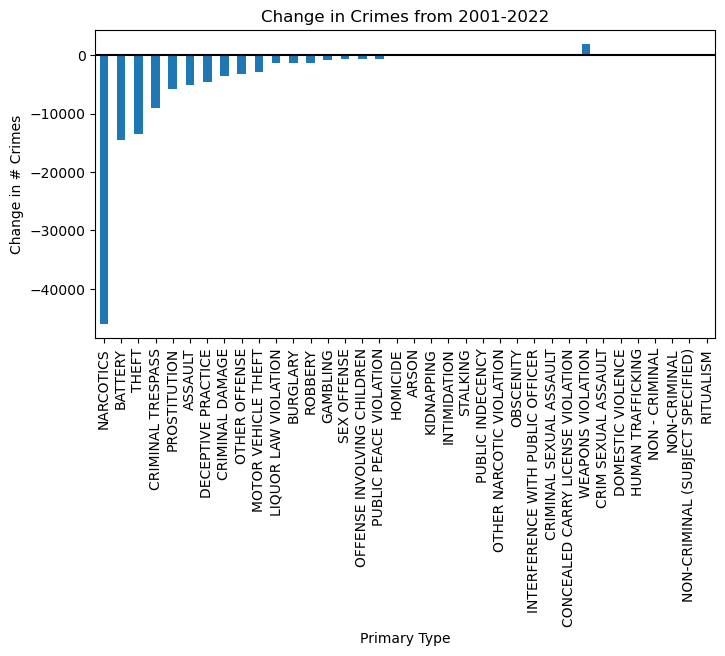

In [24]:
ax = delta_crime_yrs.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2001-2022')
ax.axhline(0,color='k');

- Most crimes have seen a large reduction in the past 22 years.
- Namely, There are far far fewer narcotics arrests made.
- There are a few crimes have seen more arrest, but most of them saw a increases in the douple or triple digits.
    - The one exception is weapons violation which saw a significant increase.

In [25]:
### Substract to get delta crmes
delta_crime_yrs2 = years_ts.loc['2022-12-31'] - years_ts.loc['2015-12-31']
delta_crime_yrs2

Primary Type
ARSON                                  -17.0
ASSAULT                              -2053.0
BATTERY                              -5660.0
BURGLARY                              -375.0
CONCEALED CARRY LICENSE VIOLATION      137.0
CRIM SEXUAL ASSAULT                      NaN
CRIMINAL DAMAGE                       -943.0
CRIMINAL SEXUAL ASSAULT                 42.0
CRIMINAL TRESPASS                    -3151.0
DECEPTIVE PRACTICE                    -754.0
DOMESTIC VIOLENCE                        NaN
GAMBLING                              -302.0
HOMICIDE                                46.0
HUMAN TRAFFICKING                       -4.0
INTERFERENCE WITH PUBLIC OFFICER      -909.0
INTIMIDATION                           -19.0
KIDNAPPING                              -5.0
LIQUOR LAW VIOLATION                   -91.0
MOTOR VEHICLE THEFT                   -425.0
NARCOTICS                           -19406.0
NON - CRIMINAL                           NaN
NON-CRIMINAL                            -1

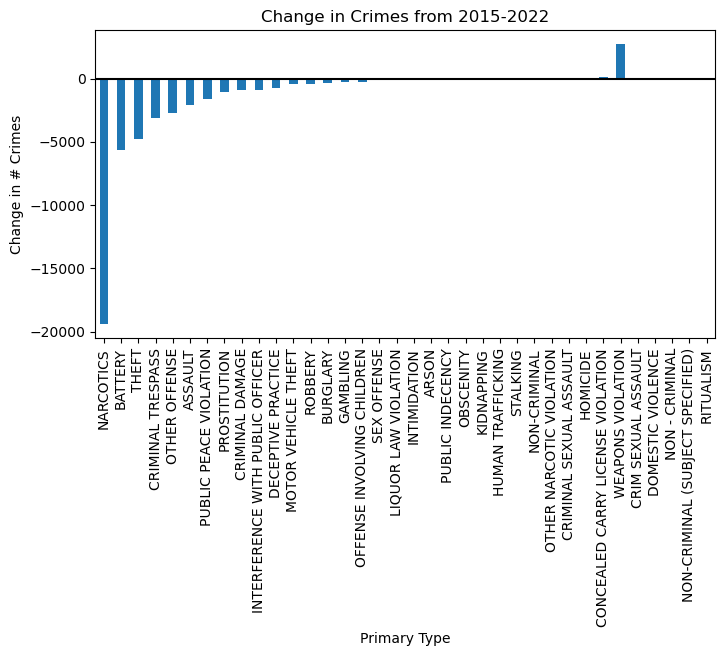

In [26]:
ax = delta_crime_yrs2.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2015-2022')
ax.axhline(0,color='k');

- In more recent years we see much of the same.
- Much fewer narcotics arrests, and much more weapons violations.

### 2. Comparing Police Districts
- Which district had the most crimes in 2022?
- Which had the least?

In [27]:
## First, resample the data as annual 
district_year  = chicago_final.groupby('District').resample('A').sum()['Arrest'].reset_index()
district_year

C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\473494814.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  district_year  = chicago_final.groupby('District').resample('A').sum()['Arrest'].reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\473494814.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  district_year  = chicago_final.groupby('District').resample('A').sum()['Arrest'].reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\473494814.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default t

District   Datetime  Arrest
0         1.0 2001-12-31    4420
1         1.0 2002-12-31    6226
2         1.0 2003-12-31    6603
3         1.0 2004-12-31    6501
4         1.0 2005-12-31    7224
..        ...        ...     ...
502      31.0 2018-12-31       1
503      31.0 2019-12-31       1
504      31.0 2020-12-31       1
505      31.0 2021-12-31       4
506      31.0 2022-12-31       9

[507 rows x 3 columns]

In [28]:
## can pivot the result to have the datetime as the index and the crime as the columns
district_ts = district_year.pivot(index='Datetime',columns='District')
district_ts

Arrest                                                           \
District      1.0      2.0     3.0     4.0     5.0     6.0     7.0     8.0    
Datetime                                                                      
2001-12-31  4420.0  13344.0  6313.0  5748.0  4995.0  6720.0  6664.0  7645.0   
2002-12-31  6226.0   9232.0  6275.0  5531.0  5481.0  6412.0  8046.0  7124.0   
2003-12-31  6603.0   8332.0  6541.0  5736.0  5071.0  6627.0  7971.0  7646.0   
2004-12-31  6501.0   7925.0  7452.0  6594.0  5768.0  7199.0  9708.0  7859.0   
2005-12-31  7224.0   6644.0  7659.0  6110.0  5456.0  6607.0  8476.0  8020.0   
2006-12-31  6411.0   5711.0  7217.0  6254.0  5387.0  6559.0  8302.0  8391.0   
2007-12-31  5316.0   6095.0  7193.0  6175.0  5586.0  8279.0  7915.0  8212.0   
2008-12-31  3607.0   4811.0  6213.0  5906.0  4538.0  7390.0  7256.0  6613.0   
2009-12-31  4370.0   4635.0  5777.0  6151.0  4557.0  6603.0  6564.0  7289.0   
2010-12-31  3041.0   4008.0  5487.0  4792.0  4247.0  6150.0  6291.0  6902.0   
2011-12-31  3520.0   3885.0  4783.0  4912.0  4262.0  6003.0  6193.0  6850.0   
2012-12-31  3330.0   3155.0  4894.0  4432.0  4354.0  5816.0  6327.0  6051.0   
2013-12-31  3468.0   3404.0  4308.0  4220.0  4085.0  5395.0  5491.0  5081.0   
2014-12-31  3260.0   2709.0  3967.0  4794.0  3882.0  4715.0  4976.0  4713.0   
2015-12-31  2803.0   1939.0  3046.0  4322.0  3085.0  4472.0  5549.0  4112.0   
2016-12-31  2547.0   1703.0  2362.0  2836.0  2701.0  3447.0  3654.0  2948.0   
2017-12-31  2469.0   1764.0  2335.0  2976.0  2968.0  3774.0  3542.0  2698.0   
2018-12-31  2370.0   1751.0  2347.0  3139.0  3067.0  4134.0  3623.0  2595.0   
2019-12-31  2539.0   1924.0  2315.0  3602.0  2912.0  4266.0  3569.0  2691.0   
2020-12-31  1586.0   1048.0  1419.0  1875.0  1662.0  2670.0  2381.0  1595.0   
2021-12-31  1287.0    772.0  1079.0  1140.0  1229.0  1807.0  1545.0  1278.0   
2022-12-31  1647.0   1049.0  1087.0  1299.0  1260.0  1584.0  1222.0  1389.0   

                            ...                                               \
District      9.0     10.0  ...    16.0    17.0    18.0    19.0    20.0 21.0   
Datetime                    ...                                                
2001-12-31  7479.0  6300.0  ...  3531.0  3528.0  6954.0  6728.0  3062.0  NaN   
2002-12-31  7699.0  6206.0  ...  3334.0  3606.0  6710.0  6714.0  2729.0  NaN   
2003-12-31  7959.0  6187.0  ...  3332.0  3357.0  5875.0  6158.0  2391.0  0.0   
2004-12-31  7337.0  7600.0  ...  3432.0  3241.0  6298.0  5451.0  2240.0  2.0   
2005-12-31  6973.0  6978.0  ...  3114.0  3625.0  6423.0  5627.0  2539.0  NaN   
2006-12-31  7547.0  6770.0  ...  2802.0  3493.0  5765.0  4744.0  2247.0  NaN   
2007-12-31  7459.0  6508.0  ...  2705.0  3044.0  5082.0  4916.0  1953.0  NaN   
2008-12-31  5713.0  5753.0  ...  2540.0  2792.0  2836.0  2567.0  1115.0  NaN   
2009-12-31  6460.0  5096.0  ...  2481.0  2596.0  4095.0  3547.0  1432.0  NaN   
2010-12-31  5391.0  5195.0  ...  2379.0  2704.0  3356.0  2959.0  1342.0  NaN   
2011-12-31  5437.0  4534.0  ...  1972.0  2430.0  3712.0  3307.0  1493.0  NaN   
2012-12-31  4569.0  4727.0  ...  1954.0  1959.0  3202.0  3266.0  1353.0  NaN   
2013-12-31  4322.0  4932.0  ...  2187.0  1578.0  3007.0  2937.0  1130.0  NaN   
2014-12-31  3769.0  4260.0  ...  2041.0  1480.0  2526.0  2653.0  1109.0  NaN   
2015-12-31  3468.0  3619.0  ...  1872.0  1239.0  2247.0  2133.0   959.0  NaN   
2016-12-31  2592.0  2951.0  ...  1453.0  1078.0  1922.0  1821.0   729.0  NaN   
2017-12-31  2438.0  3588.0  ...  1463.0   905.0  2346.0  1634.0   772.0  NaN   
2018-12-31  2162.0  4082.0  ...  1198.0   833.0  2351.0  1622.0   740.0  NaN   
2019-12-31  2348.0  4168.0  ...  1258.0   841.0  2386.0  1603.0   612.0  NaN   
2020-12-31  1577.0  2362.0  ...  1015.0   598.0  1214.0   986.0   323.0  NaN   
2021-12-31  1088.0  1510.0  ...   992.0   451.0  1156.0   802.0   342.0  NaN   
2022-12-31  1126.0  1688.0  ...  1247.0   750.0  1457.0   921.0   451.0  NaN   

                                   

In [29]:
district_ts.columns = district_ts.columns.droplevel(0)
district_ts.columns

Float64Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0,
              12.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0,
              25.0, 31.0],
             dtype='float64', name='District')

In [30]:
district_ts.loc['2022-12-31']

District
1.0     1647.0
2.0     1049.0
3.0     1087.0
4.0     1299.0
5.0     1260.0
6.0     1584.0
7.0     1222.0
8.0     1389.0
9.0     1126.0
10.0    1688.0
11.0    3097.0
12.0    1174.0
14.0     836.0
15.0    1277.0
16.0    1247.0
17.0     750.0
18.0    1457.0
19.0     921.0
20.0     451.0
21.0       NaN
22.0     769.0
24.0     844.0
25.0    1547.0
31.0       9.0
Name: 2022-12-31 00:00:00, dtype: float64

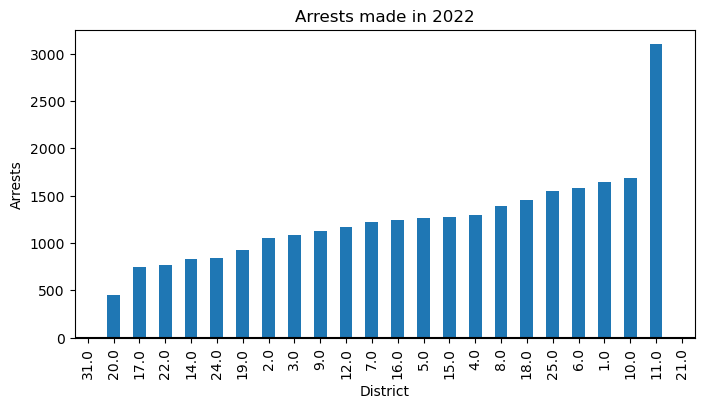

In [31]:
ax = district_ts.loc['2022-12-31'].sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Arrests',
                                       title='Arrests made in 2022')
ax.axhline(0,color='k');

- District 11 had much more arrests than any other district.
- District 31 had by far the fewest with only 9 arrests made.
- District 21 had no data, which either means there were no crimes, or they weren't recorded.

## 4. Comparing Months:
- Answer the question: ​What months have the most crime? What months have the least?
- Answer the question: Are there any individual crimes that do not follow this pattern? If so, which crimes?

#### All crimes by month

In [32]:
## Extracting the Month
chicago_final['Month'] = chicago_final.index.month
chicago_final['MonthName'] = chicago_final.index.month_name()
chicago_final.head(3)

Date Primary Type     Description  \
Datetime                                                                   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM      BATTERY          SIMPLE   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM      BATTERY          SIMPLE   
2001-01-01 01:00:00  01/01/2001 01:00:00 AM        THEFT  $500 AND UNDER   

                        Location Description  Arrest  Domestic  District  \
Datetime                                                                   
2001-01-01 01:00:00                RESIDENCE   False     False      16.0   
2001-01-01 01:00:00  RESIDENCE PORCH/HALLWAY   False     False       3.0   
2001-01-01 01:00:00            BAR OR TAVERN   False     False       3.0   

                     Month MonthName  
Datetime                              
2001-01-01 01:00:00      1   January  
2001-01-01 01:00:00      1   January  
2001-01-01 01:00:00      1   January

In [33]:
# saving lookup for number vs name
unique_months = chicago_final.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

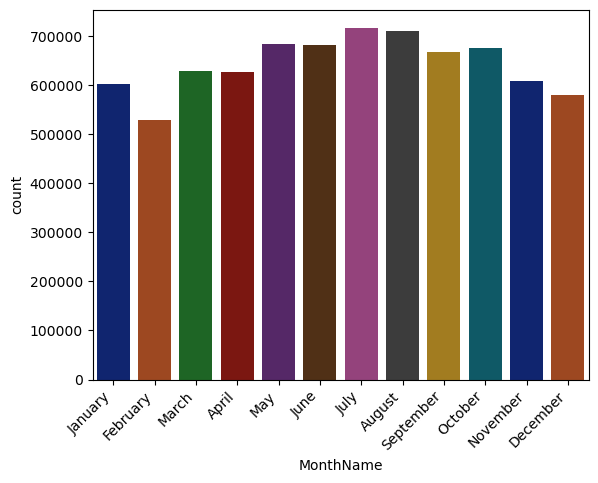

In [34]:
ax = sns.countplot(data=chicago_final, x='MonthName',palette='dark',order=month_lookup.values());
# Rotate xtick labels and align the text to the bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

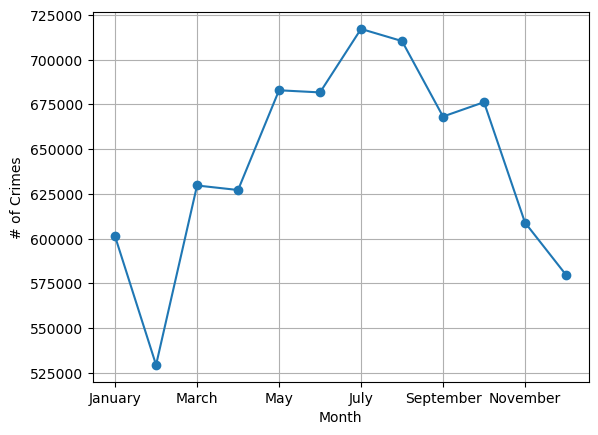

In [35]:
## save month counts
month_counts = chicago_final['MonthName'].value_counts()[month_lookup.values()]
# year_counts = df.groupby("Year").size()
ax = month_counts.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Month');

- The months with the most arrests are July and August.
- The month with the least arrests is February.

#### Individual crimes per month

In [36]:
## Get # of crimes by Hour
crimes_by_month = chicago_final.groupby('Primary Type')['Month'].value_counts().sort_index()
crimes_by_month

Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Name: Month, Length: 415, dtype: int64

In [37]:
## convert to dataframe and reset_index()
crimes_by_month_df = crimes_by_month.to_frame('# of Arrests').reset_index()
crimes_by_month_df

Primary Type  Month  # of Arrests
0                ARSON      1           917
1                ARSON      2           807
2                ARSON      3          1111
3                ARSON      4          1097
4                ARSON      5          1230
..                 ...    ...           ...
410  WEAPONS VIOLATION      8          9887
411  WEAPONS VIOLATION      9          9435
412  WEAPONS VIOLATION     10          9190
413  WEAPONS VIOLATION     11          7952
414  WEAPONS VIOLATION     12          7401

[415 rows x 3 columns]

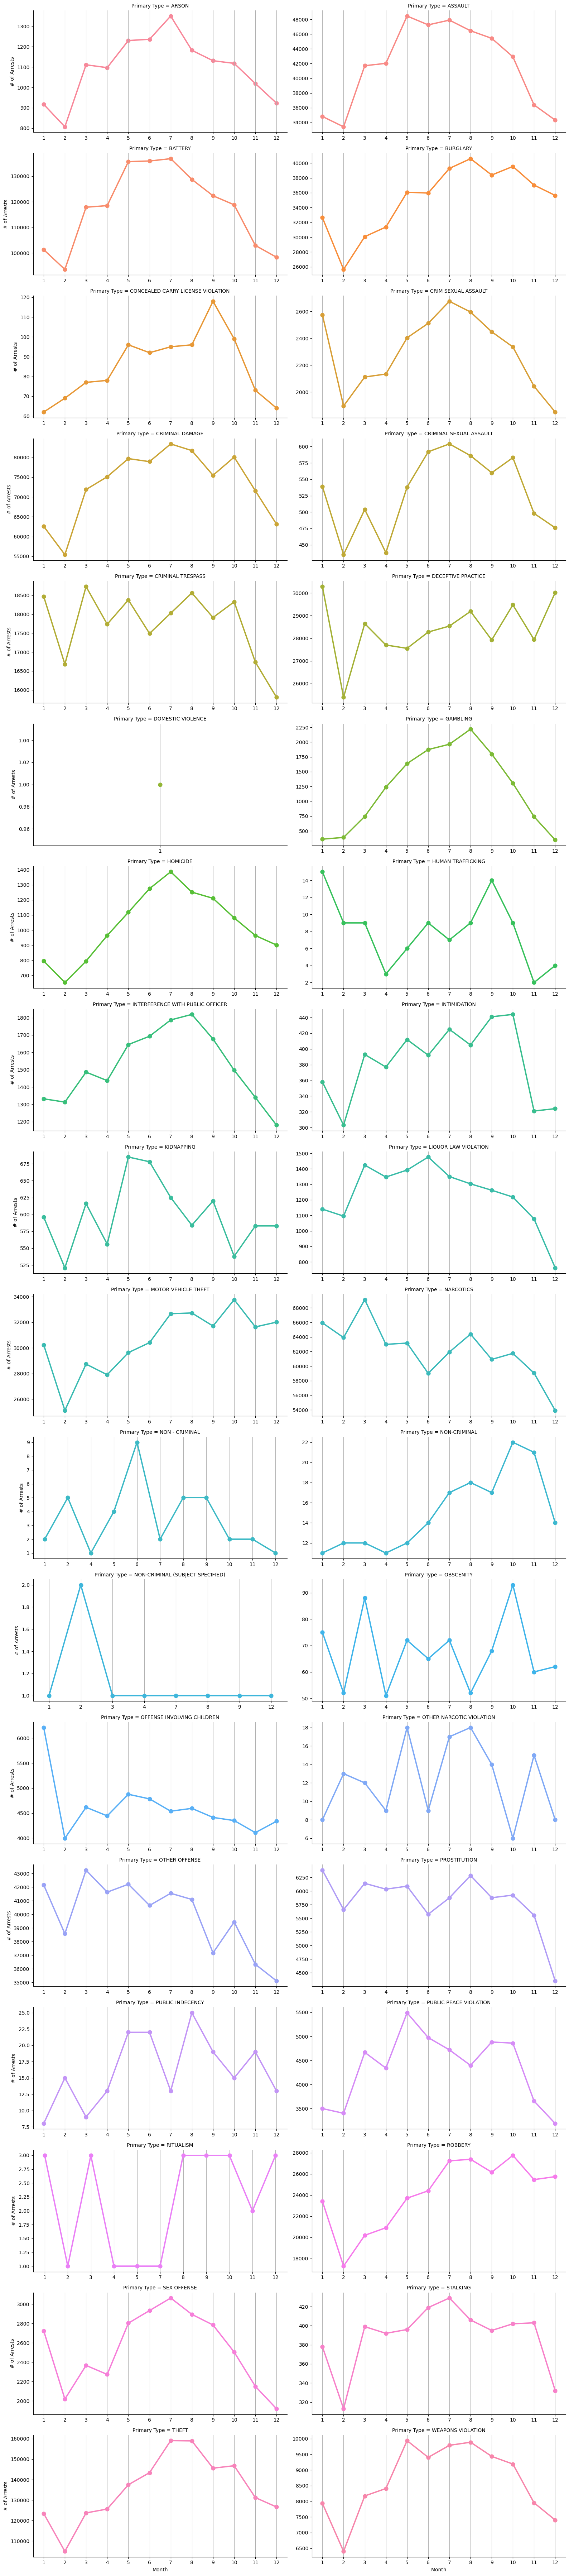

In [38]:
g = sns.catplot(data= crimes_by_month_df, x = 'Month', y = '# of Arrests',
                kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];

- There are quite a few crimes that dont follow the overall pattern.
    - Narcotics crimes go against the overall pattern which is surprising due to the sheer number of narcotics crimes.
    - Non-criminal. obscenity, offense involving children, and public peace violation all do not follow the overall pattern.
    - There are a few others, but their sample size is under 100. 

# Project 3 Part 2

## Project 3 - Part 2
For this phase of the project, you will be helping Chicago law enforcement allocate resources for the next 6 months.

You will compare the crime count forecast for 2 of the options below:

- Theft
- Battery
- Narcotics
- Assault
- Total Crime (sum of all crime types).


**For each of your selected crimes, perform the following steps to develop a forecast.**

- Transform the data to obtain a time series of the crime count per month using .size().
- Check for and address null values.
- Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
- Determine if nonseasonal and/or seasonal differencing is required
- Use the ACF and PACF plots of stationarity data to estimate initial orders
- Split the time series into training and test data (Remember we want to predict 6 months)
- Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
    - Make forecasts with your model.
    - Plot the forecasts versus the test data
    - Obtain metrics for evaluation
- Tune with pmdarima's auto_arima
    - Fit a model on training data with the best parameters from auto_arima
    - Obtain metrics for evaluation
    - Make forecasts with the auto_arima model
    - Plot the forecasts versus the test data
- Select the final model and justify your choice. (Which metrics or diagnostics support your choice?)
- Make true future forecasts using the entire dataset (for dates beyond the entire ts)

**For each of your two selected crimes, answer the following questions in a markdown cell:**

- Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
- Convert the raw delta into a percent change.

**Final Evaluation:**

After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), answer the following questions in a Markdown cell:

- Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
- Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
- Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?

Final Recommendations

- What recommendation would you make to the stakeholders?
- Include reporting-quality visual(s) to support your recommendation.

## Resampling as months

In [39]:
## First, resample the data as annual 
full_month  = chicago_final.groupby('Primary Type').resample('M').sum()['Arrest'].reset_index()
full_month

C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\2828036428.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_month  = chicago_final.groupby('Primary Type').resample('M').sum()['Arrest'].reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\2828036428.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_month  = chicago_final.groupby('Primary Type').resample('M').sum()['Arrest'].reset_index()
C:\Users\thoma\AppData\Local\Temp\ipykernel_21156\2828036428.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will defa

Primary Type   Datetime  Arrest
0                 ARSON 2001-01-31      14
1                 ARSON 2001-02-28       7
2                 ARSON 2001-03-31      17
3                 ARSON 2001-04-30      28
4                 ARSON 2001-05-31      19
...                 ...        ...     ...
8597  WEAPONS VIOLATION 2022-08-31     492
8598  WEAPONS VIOLATION 2022-09-30     490
8599  WEAPONS VIOLATION 2022-10-31     416
8600  WEAPONS VIOLATION 2022-11-30     317
8601  WEAPONS VIOLATION 2022-12-31     315

[8602 rows x 3 columns]

In [40]:
## can pivot the result to have the datetime as the index and the crime as the columns
months_ts = full_month.pivot(index='Datetime',columns='Primary Type')
months_ts.head()

Arrest                           \
Primary Type  ARSON ASSAULT BATTERY BURGLARY   
Datetime                                       
2001-01-31     14.0   515.0  1499.0    117.0   
2001-02-28      7.0   501.0  1433.0    107.0   
2001-03-31     17.0   631.0  1660.0    130.0   
2001-04-30     28.0   639.0  1845.0    129.0   
2001-05-31     19.0   638.0  1921.0    112.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Datetime                                                             
2001-01-31                                 NaN                40.0   
2001-02-28                                 NaN                36.0   
2001-03-31                                 NaN                29.0   
2001-04-30                                 NaN                35.0   
2001-05-31                                 1.0                29.0   

                                                                        \
Primary Type CRIMINAL DAMAGE CRIMINAL SEXUAL ASSAULT CRIMINAL TRESPASS   
Datetime                                                                 
2001-01-31             337.0                     1.0            1014.0   
2001-02-28             333.0                     0.0             838.0   
2001-03-31             372.0                     2.0             877.0   
2001-04-30             448.0                     1.0             894.0   
2001-05-31             390.0                     0.0             830.0   

                                 ...                             \
Primary Type DECEPTIVE PRACTICE  ... OTHER OFFENSE PROSTITUTION   
Datetime                         ...                              
2001-01-31                467.0  ...         361.0        563.0   
2001-02-28                410.0  ...         384.0        425.0   
2001-03-31                471.0  ...         439.0        550.0   
2001-04-30                405.0  ...         402.0        564.0   
2001-05-31                455.0  ...         515.0        503.0   

                                                                        \
Primary Type PUBLIC INDECENCY PUBLIC PEACE VIOLATION RITUALISM ROBBERY   
Datetime                                                                 
2001-01-31                NaN                   45.0       0.0   197.0   
2001-02-28                1.0                   53.0       0.0   139.0   
2001-03-31                0.0                   91.0       0.0   142.0   
2001-04-30                1.0                   73.0       0.0   124.0   
2001-05-31                1.0                   73.0       0.0   160.0   

                                                             
Primary Type SEX OFFENSE STALKING   THEFT WEAPONS VIOLATION  
Datetime                                                     
2001-01-31          70.0      8.0  1426.0             275.0  
2001-02-28          58.0      4.0  1139.0             222.0  
2001-03-31          70.0      3.0  1283.0             240.0  
2001-04-30          74.0      8.0  1227.0             267.0  
2001-05-31          90.0      6.0  1290.0             314.0  

[5 rows x 36 columns]

In [41]:
months_ts.columns

MultiIndex([('Arrest',                             'ARSON'),
            ('Arrest',                           'ASSAULT'),
            ('Arrest',                           'BATTERY'),
            ('Arrest',                          'BURGLARY'),
            ('Arrest', 'CONCEALED CARRY LICENSE VIOLATION'),
            ('Arrest',               'CRIM SEXUAL ASSAULT'),
            ('Arrest',                   'CRIMINAL DAMAGE'),
            ('Arrest',           'CRIMINAL SEXUAL ASSAULT'),
            ('Arrest',                 'CRIMINAL TRESPASS'),
            ('Arrest',                'DECEPTIVE PRACTICE'),
            ('Arrest',                 'DOMESTIC VIOLENCE'),
            ('Arrest',                          'GAMBLING'),
            ('Arrest',                          'HOMICIDE'),
            ('Arrest',                 'HUMAN TRAFFICKING'),
            ('Arrest',  'INTERFERENCE WITH PUBLIC OFFICER'),
            ('Arrest',                      'INTIMIDATION'),
            ('Arrest',  

## Narcotics

### data prep

In [42]:
nar_ts = months_ts['Arrest']
nar_ts = nar_ts['NARCOTICS']
nar_ts

Datetime
2001-01-31    4714.0
2001-02-28    4369.0
2001-03-31    4861.0
2001-04-30    4043.0
2001-05-31    4038.0
               ...  
2022-08-31     410.0
2022-09-30     370.0
2022-10-31     341.0
2022-11-30     319.0
2022-12-31     309.0
Name: NARCOTICS, Length: 264, dtype: float64

- We are attemptign to forecast 6 months.
- So in order to make the data more significant I'll limit the data used to 2017 onwards.

In [43]:
nar_ts = nar_ts.loc['2017':]
nar_ts

Datetime
2017-01-31     984.0
2017-02-28     956.0
2017-03-31    1127.0
2017-04-30    1042.0
2017-05-31    1118.0
               ...  
2022-08-31     410.0
2022-09-30     370.0
2022-10-31     341.0
2022-11-30     319.0
2022-12-31     309.0
Name: NARCOTICS, Length: 72, dtype: float64

In [44]:
nar_ts.isna().sum()

0

### Determining the correct model

<Axes: xlabel='Datetime'>

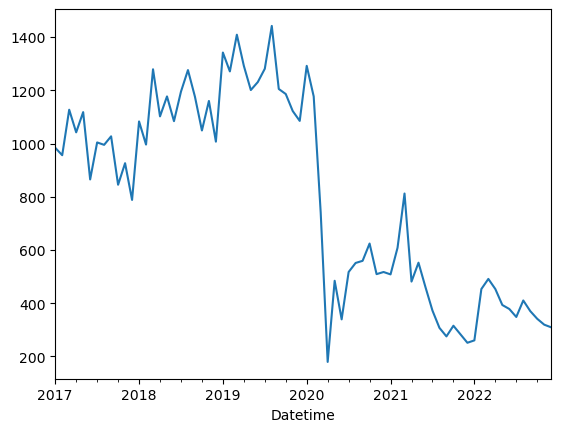

In [45]:
nar_ts.plot()

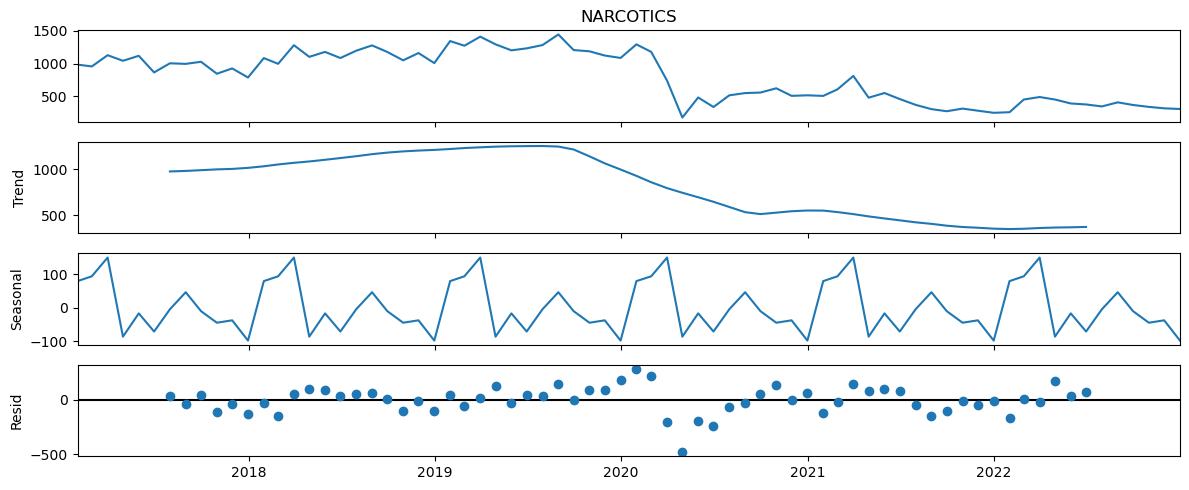

In [46]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(nar_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

- Seasonality seem likely, although there are many residuals.

In [47]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(nar_ts.max() - nar_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 247.01666666666665 which is ~19.56% of the variation in time series.


- seasonality accoutnign for 10% seems to point towards seasonal trends.

In [48]:
# check for nonseasonal differencing
ndiffs(nar_ts)

1

In [49]:
nar_ts_diff = nar_ts.diff().dropna()

In [50]:
# Check for seasonal differcing
nsdiffs(nar_ts, m = 12)

0

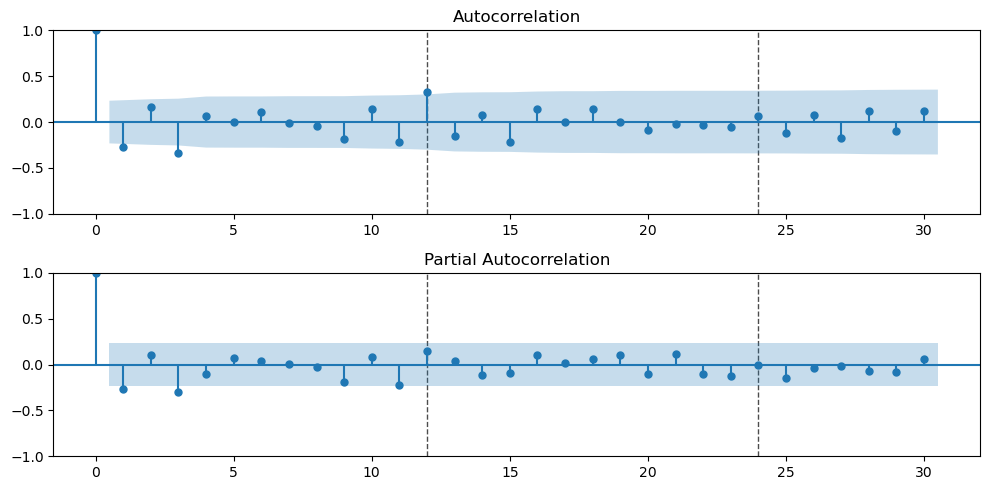

In [51]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(nar_ts_diff, annotate_seas=True, m = 12, nlags = 30);

- Both the ACF and the PACF taper off rather slowly, I'll start with 1,1.

### Train Test Split

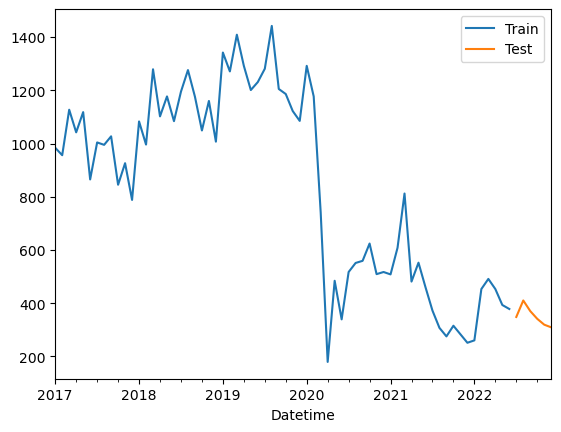

In [97]:
# tts so test size is 24 lags
test_lags = 6 
train, test = train_test_split(nar_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### Manual Model

In [53]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                   66
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -416.306
Date:                          Thu, 26 Oct 2023   AIC                            842.613
Time:                                  23:30:25   BIC                            853.485
Sample:                              01-31-2017   HQIC                           846.902
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9766      0.047    -20.875      0.000      -1.068      -0.885
ma.L1          0.9127      0.094      9.659      0.000       0.728       1.098
ar.S.L12       0.0762      1.037      0.073      0.941      -1.957       2.109
ma.S.L12       0.1972      1.074      0.184      0.854      -1.908       2.303
sigma2      2.098e+04   2909.537      7.210      0.000    1.53e+04    2.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                37.10
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.92
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

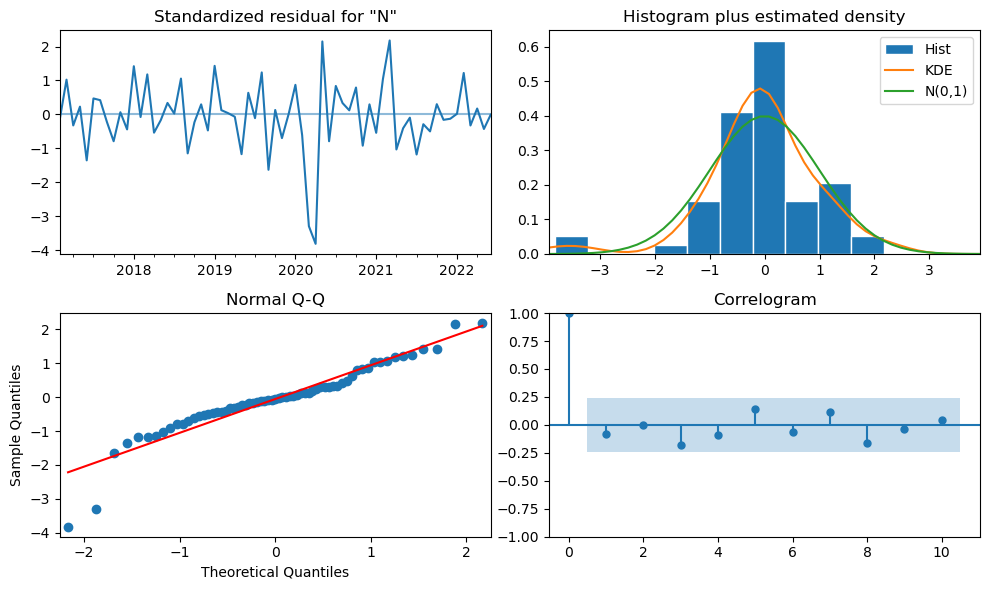

In [54]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 28.457
- MSE = 1,791.899
- RMSE = 42.331
- R^2 = -0.599
- MAPE = 7.44%


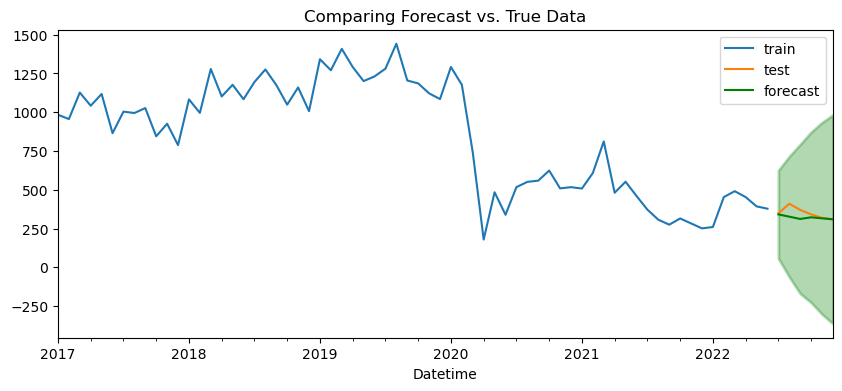

In [55]:
# Obtain forecast as a dataframe with confidence intervals
nar_forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, nar_forecast_df);
# Obtain metrics
regression_metrics_ts(test, nar_forecast_df['mean'])

- A Fairly high MAPE value of 7.44%, this could be for a few reasons.
    - Most likely because I'm not entirely sure how to pick the seasonal paramters.

### Auto ARIMA optimization

In [56]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=849.361, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=842.866, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=843.238, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=847.578, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=846.572, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=844.832, Time=0.14 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=844.801, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=842.902, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=843.300, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=844.145, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=842.615, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=845.222, Time=0.06 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AI

In [57]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(0, 0, 1, 12)


In [58]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 0 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                   66
Model:             ARIMA(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -416.316
Date:                          Thu, 26 Oct 2023   AIC                            840.633
Time:                                  23:30:32   BIC                            849.330
Sample:                              01-31-2017   HQIC                           844.065
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9775      0.035    -28.103      0.000      -1.046      -0.909
ma.L1          0.9139      0.066     13.809      0.000       0.784       1.044
ma.S.L12       0.2697      0.111      2.438      0.015       0.053       0.487
sigma2      2.098e+04   2582.972      8.123      0.000    1.59e+04     2.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                36.50
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.91
Prob(H) (two-sided):                  0.73   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

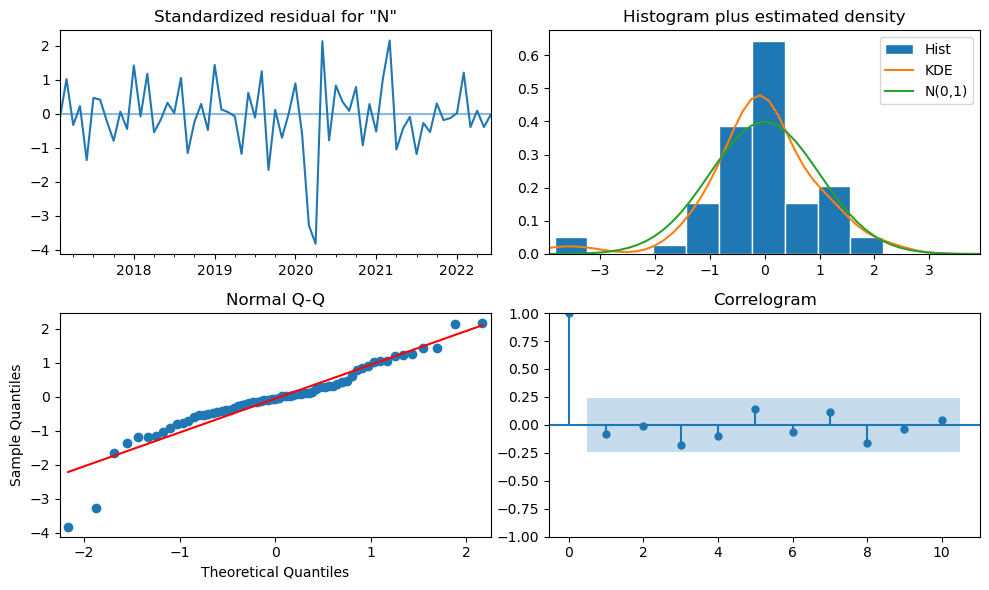

In [59]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 31.157
- MSE = 1,945.282
- RMSE = 44.105
- R^2 = -0.735
- MAPE = 8.23%


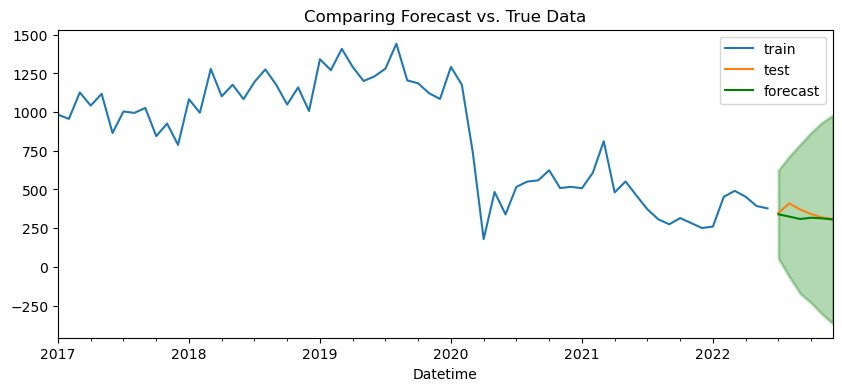

In [60]:
# Obtain summary of forecast as dataframe
nar_forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, nar_forecast_df)
# Obtain metrics
regression_metrics_ts(test, nar_forecast_df["mean"])

- The auto ARIMA model has slightly more error than the manual model, so I'll stick with the manual model.

### Choosing final model

In [98]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

nar_final_model = tsa.ARIMA(nar_ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


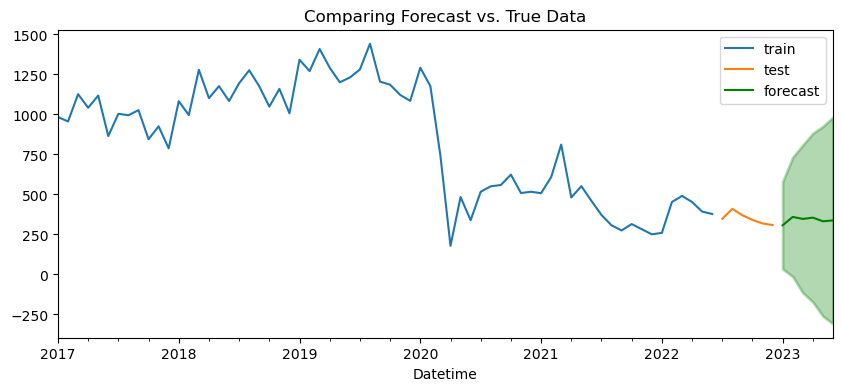

In [99]:
# Obtain future forecasts beyond test data
nar_forecast_df  = nar_final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,nar_forecast_df);

## Assault

### Data prep

In [66]:
as_ts = months_ts['Arrest']
as_ts = as_ts['ASSAULT']
as_ts

Datetime
2001-01-31    515.0
2001-02-28    501.0
2001-03-31    631.0
2001-04-30    639.0
2001-05-31    638.0
              ...  
2022-08-31    208.0
2022-09-30    187.0
2022-10-31    158.0
2022-11-30    144.0
2022-12-31    149.0
Name: ASSAULT, Length: 264, dtype: float64

- We are attemptign to forecast 6 months.
- So in order to make the data more significant I'll limit the data used to 2017 onwards.

In [67]:
as_ts = as_ts.loc['2017':]
as_ts

Datetime
2017-01-31    234.0
2017-02-28    263.0
2017-03-31    272.0
2017-04-30    313.0
2017-05-31    328.0
              ...  
2022-08-31    208.0
2022-09-30    187.0
2022-10-31    158.0
2022-11-30    144.0
2022-12-31    149.0
Name: ASSAULT, Length: 72, dtype: float64

In [68]:
nar_ts.isna().sum()

0

### Determining Model

<Axes: xlabel='Datetime'>

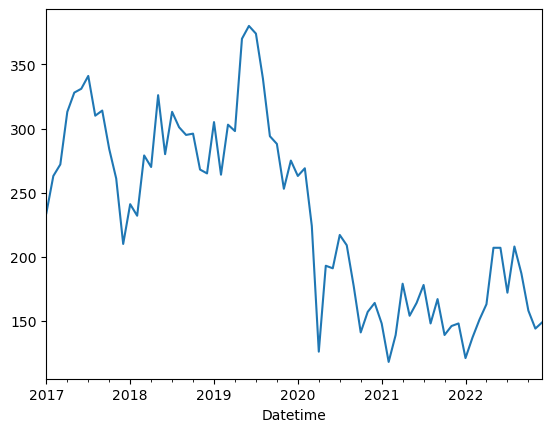

In [69]:
as_ts.plot()

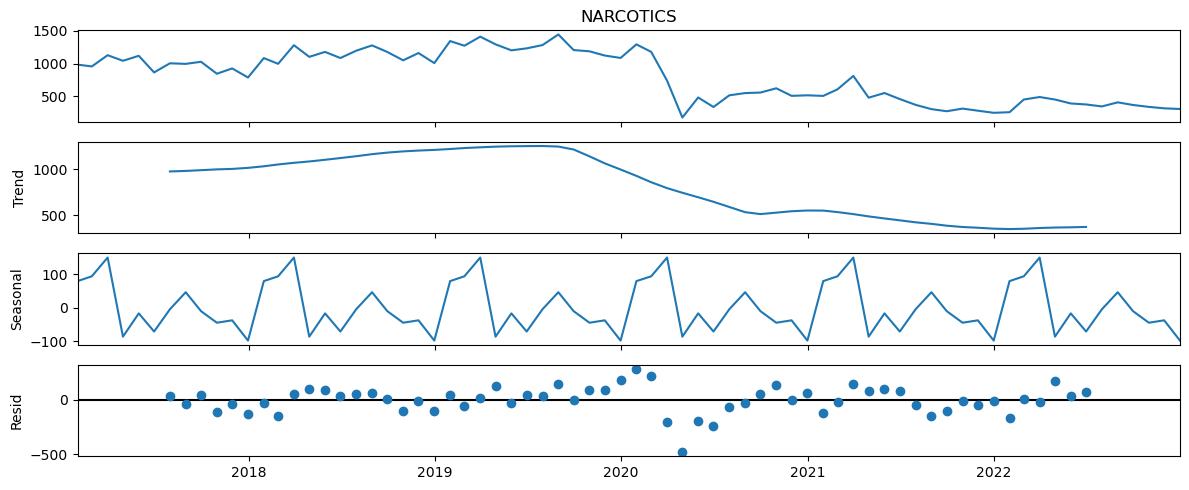

In [70]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(nar_ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

- Seasonality is in question
- The trend lines are concerning, and the residuals are a but sporatice.
- I will continue with the idea that the data is seasonal.

In [71]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(as_ts.max() - as_ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 247.01666666666665 which is ~94.28% of the variation in time series.


- 94.3%?

In [72]:
# check for nonseasonal differencing
ndiffs(as_ts)

1

In [73]:
as_ts_diff = as_ts.diff().dropna()

In [74]:
# Check for seasonal differcing
nsdiffs(as_ts, m = 12)

0

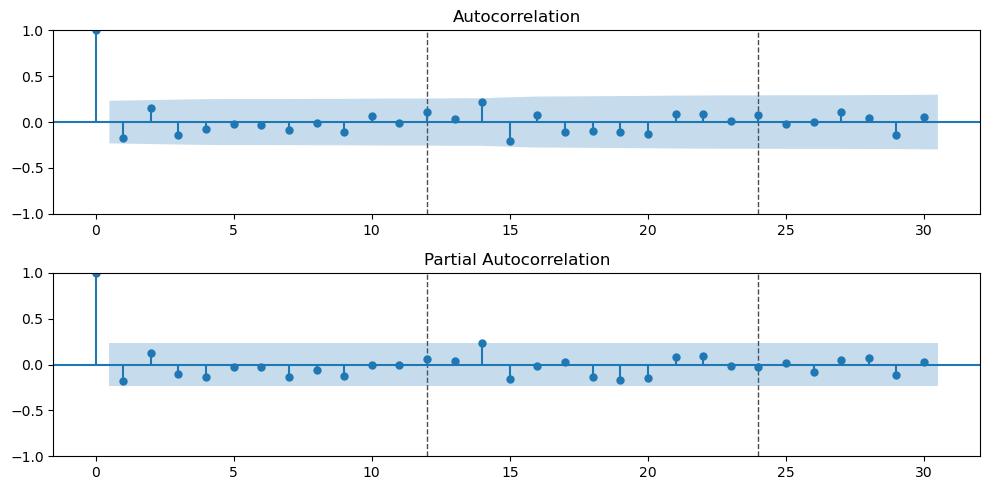

In [75]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(as_ts_diff, annotate_seas=True, m = 12, nlags = 30);

- Both the ACF and PACF have immediate dips, I'll start with 0,0

### Train Test Split

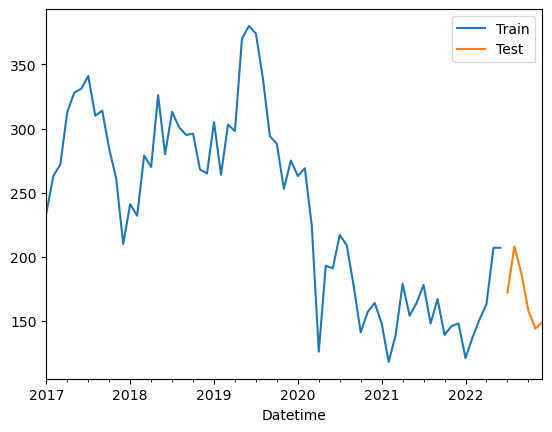

In [100]:
# tts so test size is 24 lags
test_lags = 6 
train, test = train_test_split(as_ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [77]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          ASSAULT   No. Observations:                   66
Model:             ARIMA(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -314.978
Date:                          Thu, 26 Oct 2023   AIC                            633.957
Time:                                  23:31:54   BIC                            638.305
Sample:                              01-31-2017   HQIC                           635.673
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1467      0.105      1.398      0.162      -0.059       0.352
sigma2       943.6726    158.030      5.971      0.000     633.939    1253.406
===================================================================================
Ljung-Box (L1) (Q):                   2.15   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.14   Prob(JB):                         0.69
Heteroskedasticity (H):               0.78   Skew:                            -0.23
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

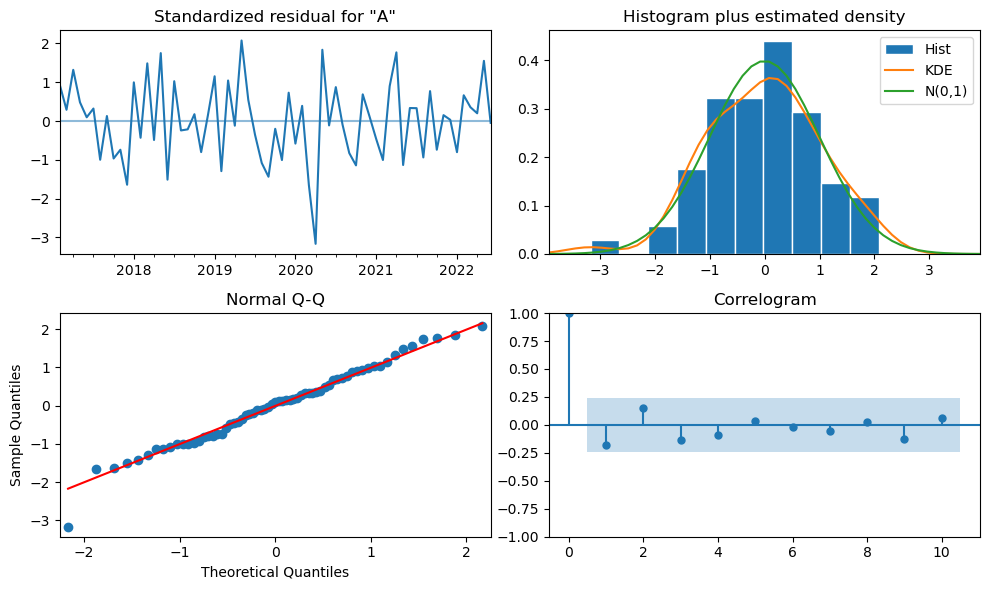

In [78]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37.031
- MSE = 1,766.243
- RMSE = 42.027
- R^2 = -2.536
- MAPE = 23.67%


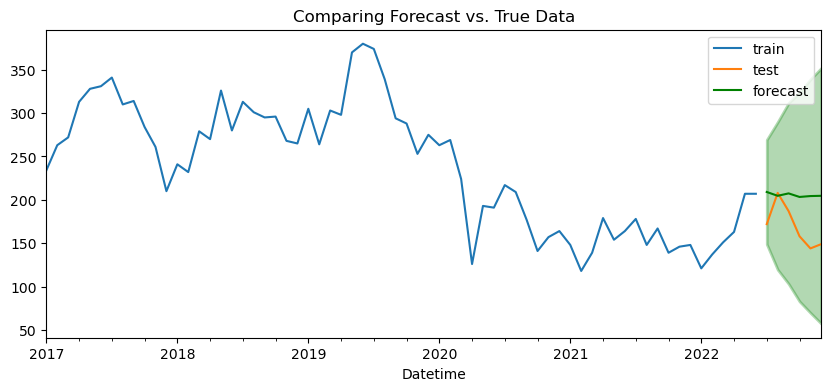

In [79]:
# Obtain forecast as a dataframe with confidence intervals
as_forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, as_forecast_df);
# Obtain metrics
regression_metrics_ts(test, as_forecast_df['mean'])

- This model is horrendous. Not sure which value is off.
- Possibly the model is not seasonal, but I'm not sure how to account for the pseudo-seasonal dips.

### Auto ARIMA optimization

In [80]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=635.296, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=635.918, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=636.506, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=633.308, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=635.953, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=636.136, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=635.373, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=635.831, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=636.217, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.994 seconds


In [81]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(0, 1, 0)
(0, 0, 0, 12)


- Best model found is not seasonal

In [82]:
# Orders for non seasonal components
p = 0 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA
auto_arima = tsa.ARIMA(train, order = (p,d,q)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_arima.summary()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ASSAULT   No. Observations:                   66
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -315.654
Date:                Thu, 26 Oct 2023   AIC                            633.308
Time:                        23:32:02   BIC                            635.482
Sample:                    01-31-2017   HQIC                           634.166
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       967.3516    155.301      6.229      0.000     662.967    1271.736
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.16   Prob(JB):                         0.74
Heteroskedasticity (H):               0.65   Skew:                            -0.14
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

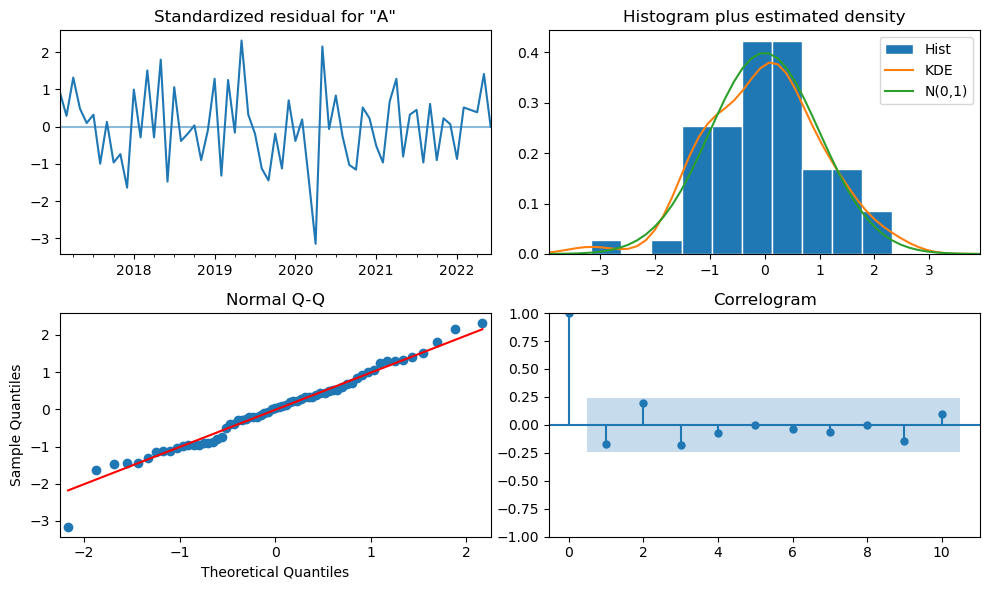

In [83]:
# Obtain diagnostic plots
fig = auto_arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 37.667
- MSE = 1,893.333
- RMSE = 43.512
- R^2 = -2.790
- MAPE = 24.20%


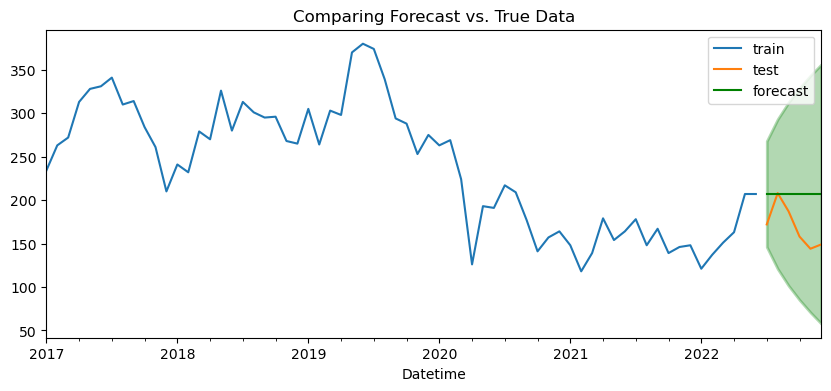

In [84]:
# Obtain summary of forecast as dataframe
forecast_df = auto_arima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

- It's even worse.

### Guess and Check

In [85]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

guess_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                   66
Model:             ARIMA(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -416.316
Date:                          Thu, 26 Oct 2023   AIC                            840.633
Time:                                  23:32:14   BIC                            849.330
Sample:                              01-31-2017   HQIC                           844.065
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9775      0.035    -28.103      0.000      -1.046      -0.909
ma.L1          0.9139      0.066     13.809      0.000       0.784       1.044
ma.S.L12       0.2697      0.111      2.438      0.015       0.053       0.487
sigma2      2.098e+04   2582.972      8.123      0.000    1.59e+04     2.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                36.50
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.91
Prob(H) (two-sided):                  0.73   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

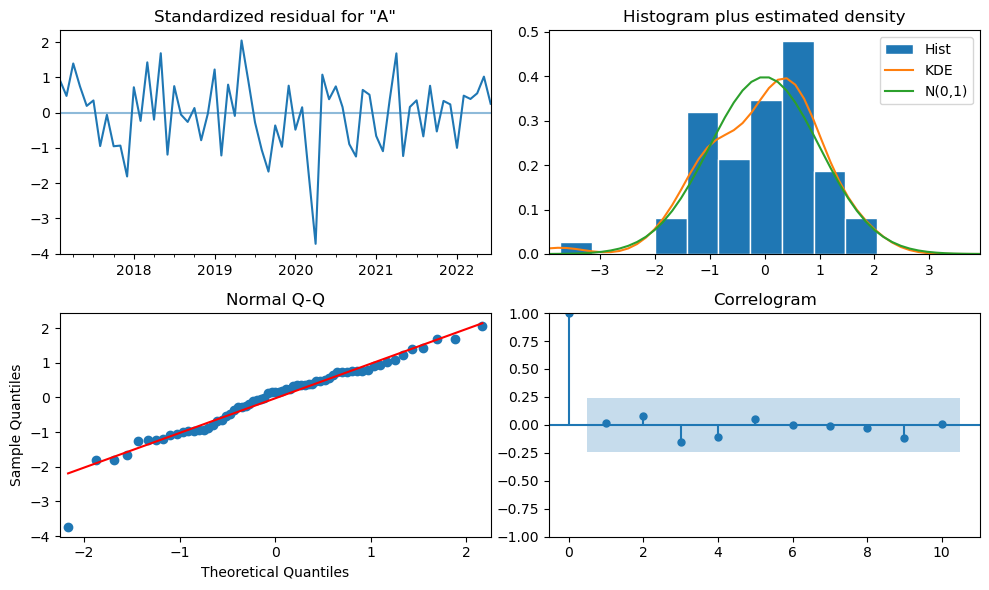

In [86]:
# Obtain diagnostic plots 
fig = guess_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 26.620
- MSE = 901.710
- RMSE = 30.028
- R^2 = -0.805
- MAPE = 16.80%


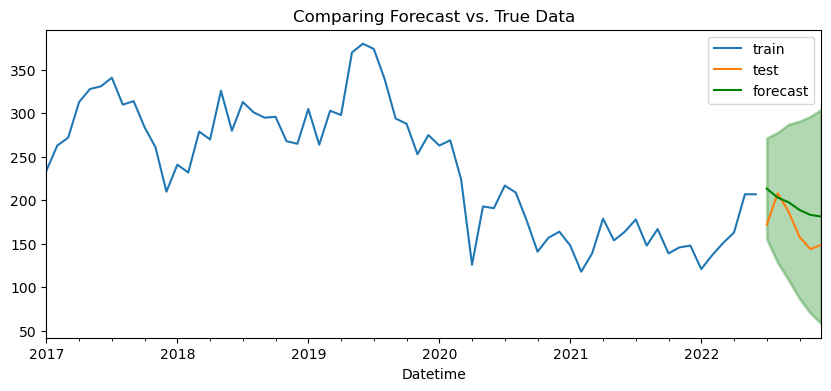

In [87]:
# Obtain forecast as a datatime with confidence intervals
forecast_df = guess_sarima.get_forecast(steps = len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics 
regression_metrics_ts(test, forecast_df['mean'])

- Still not a great model by any means, but it is the best I have.

### Choosing Final Model

In [101]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

as_final_model = tsa.ARIMA(as_ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
S:\Users\thoma\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


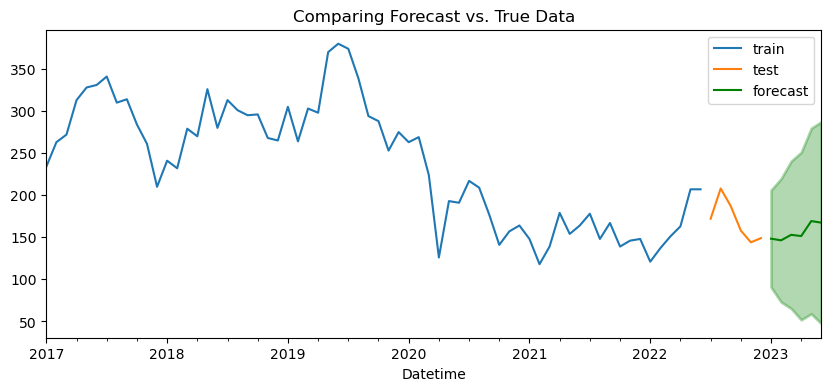

In [106]:
# Obtain future forecasts beyond test data
as_forecast_df  = as_final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,as_forecast_df);

## Comparing Data

### Narcotics

In [113]:
nar_starting_value = nar_forecast_df['mean'].iloc[0]
nar_starting_value

307.1141586685085

In [114]:
nar_final_value = nar_forecast_df['mean'].iloc[-1]
nar_final_value

337.58512364664864

In [121]:
nar_change = nar_final_value - nar_starting_value
nar_change

30.47096497814016

In [122]:
nar_perc_change = (nar_change / nar_starting_value) * 100
nar_perc_change

9.921706348625161

### Assault

In [117]:
as_starting_value = as_forecast_df['mean'].iloc[0]
as_starting_value

148.3354884389676

In [118]:
as_final_value = as_forecast_df['mean'].iloc[-1]
as_final_value

167.33762874765486

In [119]:
as_change = as_final_value - as_starting_value
as_change

19.002140308687274

In [120]:
as_perc_change = (as_change / as_starting_value) * 100
as_perc_change

12.810245551256386

## Analysis

- There are forecasted to be roughly 170 more narcotics arrests made in 6 months.
- Narcotics will see 30 more arrests made, compared to assaults having 19 more.
- Assaulst are going to have an overall larger percent increase in arrests.

# Final Thoughts

- I would recommend upping enforcement/awareness of all crimes over summer months.
- In most crimes May through August/September see the most arrests made.
    - Now this does raise a good question:
        - Since this data only records arrests, have they already upped enforcement in these months.
        - It could already be beleived that crimes are seasonal so more cops are out, resulting in higer arrest rates.
        - There could possibly be an argument that the crimes are not seasonl, but the enforcement is.

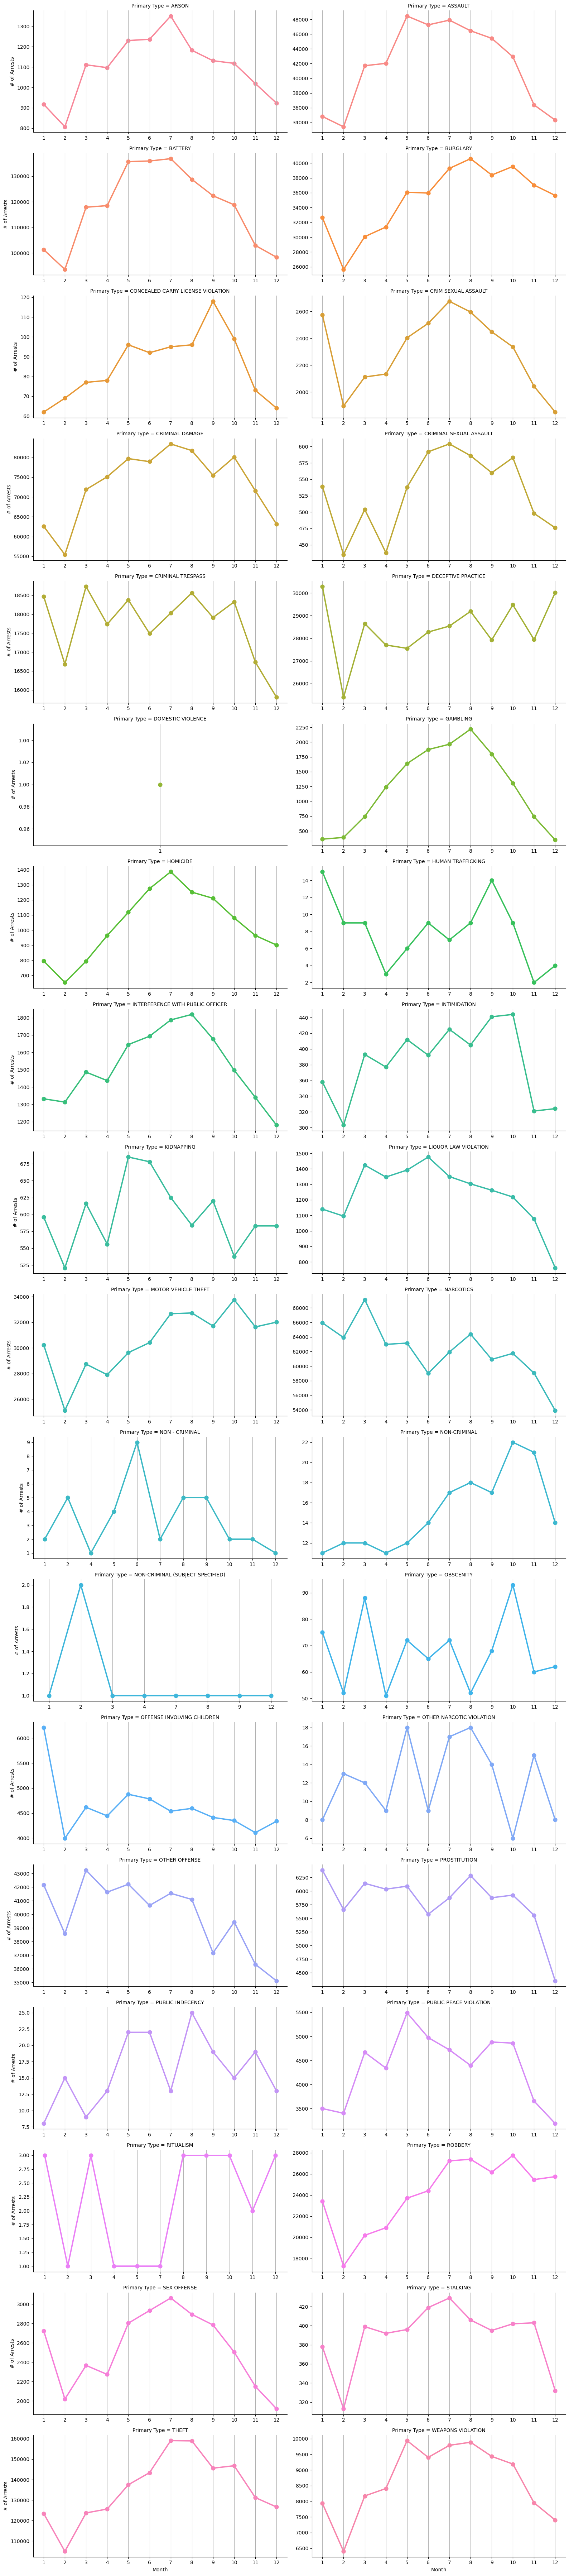

In [124]:
g = sns.catplot(data= crimes_by_month_df, x = 'Month', y = '# of Arrests',
                kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];